In [23]:
import os
import numpy as np
import pylab as pl

In [20]:
from desisim.specsim import get_simulator

In [13]:
# Wavelengths of OII doublet.
lambdaa = 3727.092 # Angstroms
lambdab = 3729.875 # Angstorms

# Energy weighted mean.
OII     = 3728.483

# Width of each line due to thermal broadening.
def width(center, dv):    
    # velocity difference [speed of light]
    return  center * dv

Text(0, 0.5, 'Normalised flux')

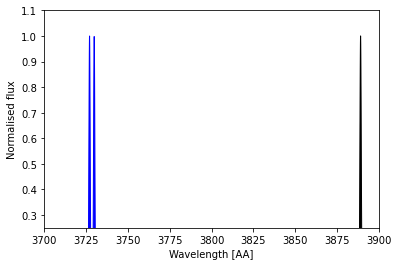

In [14]:
wave     = np.arange(1000, 1.e4, 0.05)

dlambdaa = width(lambdaa, 1.e-4)
dlambdab = width(lambdab, 1.e-4) 

def gaussian(wave, center, width):
    #  https://en.wikipedia.org/wiki/Gaussian_function 
    norm = np.sqrt(2. * np.pi / width)
    
    return  np.exp(-0.5 * (wave - center)**2. / width**2.)

ax       = pl.gca()

ax.fill_between(wave, 0., gaussian(wave, lambdaa, dlambdaa), color='b', alpha=1.0)
ax.fill_between(wave, 0., gaussian(wave, lambdab, dlambdab), color='b', alpha=1.0)

ax.fill_between(wave, 0., gaussian(wave, 3889.0, width(3889.0, 1.e-4)), color='k', alpha=1.)

pl.xlim(3700., 3900.)
pl.ylim(0.25, 1.1)

pl.xlabel('Wavelength [AA]')
pl.ylabel('Normalised flux')

In [15]:
def dlamba_inst(R, z, center):
    # eqn. (2) of https://arxiv.org/pdf/1310.0615.pdf
    return  (1. + z) * center / R # [Angstroms]

In [16]:
def dlamba_tot(R, z, center, v=1.e-4):
    # Widths of Gaussians add in quadrature; (https://en.wikipedia.org/wiki/Propagation_of_uncertainty).
    return np.sqrt(dlamba_inst(R, z, center)**2. + width(center, v)**2.)

In [17]:
R       = 9.e3
z       = 1.00

In [18]:
dlambda = OII * (1 + z) / R  # [Angstroms].

In [19]:
# width of a pixel in Angstroms, rather than a resolution element.
dlambda  /= 3.

In [24]:
os.environ['DESIMODEL'] = '/Users/MJWilson/Work/desi/latest/desimodel/0.13.1' 

In [25]:
simulator = get_simulator(config='desi', num_fibers=1, camera_output=True)

/Users/MJWilson/opt/miniconda3/envs/desi/lib/python3.6/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
